<h3 style="text-align:center">Image and text classification using CNN</h3>

Image classification

In [17]:
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inferencing

In [19]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    labels = eval(f.read())

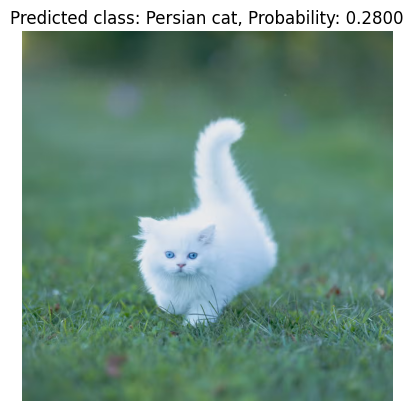

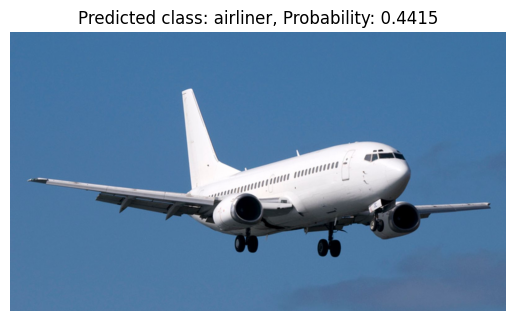

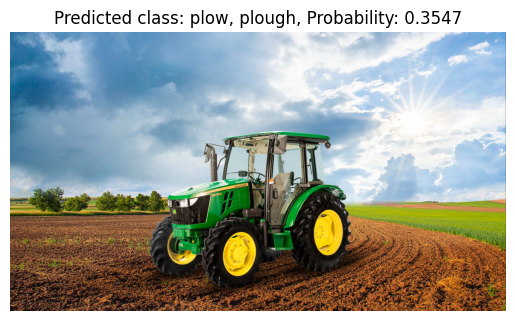

In [22]:
preprocessor = ResNet50_Weights.IMAGENET1K_V2.transforms()
test_images = ["cat.png", "plane.png", "tractor.png"]

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for img_path in test_images:
    test_image = Image.open(img_path).convert("RGB")
    # test_image = T.ToTensor()(test_image)
    input_image = transforms(test_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)

    predicted_probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_probabilities, predicted_classes = torch.topk(predicted_probabilities, 5)

    label = labels[predicted_classes[0].item()]
    probability = predicted_probabilities[0].item()

    plt.imshow(test_image)
    plt.axis('off')
    plt.title(f"Predicted class: {label}, Probability: {probability:.4f}")
    plt.show()

Text classification

In [16]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [15]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hrishikesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/hrishikesh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
dataset = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [8]:
dataset

{'data': ['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
  "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and 

Creating a CNN for text classification

In [9]:
x = torch.randint(0, 1000, (100, 50))  # Example input data
x = torch.nn.Embedding(1000, 64)(x)  # Embedding layer
print(x.shape)  # Should be (100, 50, 64)
x = x.permute(0, 2, 1)  # Change shape to
print(x.shape)  # Should be (100, 64, 50)
x = nn.Conv1d(64, 32, kernel_size=3)(x)
print(x.shape)  # Should be (100, 32, 48)
x = nn.ReLU()(x)
x = nn.MaxPool1d(kernel_size=2)(x)
print(x.shape)  # Should be (100, 32, 24)

x = x.view(x.size(0), -1)  # Flatten
print(x.shape)  # Should be (100, 32*24)


torch.Size([100, 50, 64])
torch.Size([100, 64, 50])
torch.Size([100, 32, 48])
torch.Size([100, 32, 24])
torch.Size([100, 768])


In [10]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Conv1d(embed_dim, 128, 3)
        self.conv2 = nn.Conv1d(128, 64, 3)
        self.conv3 = nn.Conv1d(64, 32, 3)

        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


In [12]:
dataset_df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

In [13]:
dataset_df

,text,label
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14
...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",4
11311,I just installed a DX2-66 CPU in a clone mothe...,3
11312,\nWouldn't this require a hyper-sphere. In 3-...,1


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = nltk.word_tokenize(text)
    text = ' '.join([word for word in text if word not in stop_words])
    return text